In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub
!pip install shap

In [12]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Dataset
import numpy as np
import torch
from torch.utils.data import DataLoader
import re

dataset = load_dataset("solomonk/reddit_mental_health_posts")

def not_none(example):
    return example['body'] is not None

dataset = dataset.filter(not_none)


def filter_text(example):
  len_body = len(example['body'])
  if len_body>=500:
    return True
  return False

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def prepare_dataframe(df):
  # Concatenate title and body
  df['body'] = df.body.fillna('')
  df['body'] = df.body.str.cat(df.title, sep=' ')

  # Removed deleted posts
  df = df[~df.author.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[removed\]')]
  df = df[~df.body.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[deleted by user\]')]

  # Removed moderador posts
  df = df[df.author!='AutoModerator']

  return df[['body', 'subreddit']]

#def not_none(example):
#    return example['body'] is not None

df = dataset["train"].to_pandas()
df = prepare_dataframe(df).reset_index(drop=True)
dataset = Dataset.from_pandas(df)

dataset_sampled = dataset.train_test_split(test_size=0.7, seed=42)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']

columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

le = LabelEncoder()

le.fit(dataset_sampled['subreddit'])

def encode_labels(example):
    example['subreddit'] = le.transform([example['subreddit']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
validation_dataset = validation_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def prepare_data(example):
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(example['subreddit'], dtype=torch.long)
    }

train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
result = trainer.evaluate(test_dataset)

Repo card metadata block was not found. Setting CardData to empty.


Map:   0%|          | 0/19978 [00:00<?, ? examples/s]

Map:   0%|          | 0/2497 [00:00<?, ? examples/s]

Map:   0%|          | 0/2498 [00:00<?, ? examples/s]

Map:   0%|          | 0/19978 [00:00<?, ? examples/s]

Map:   0%|          | 0/2497 [00:00<?, ? examples/s]

Map:   0%|          | 0/2498 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Step,Training Loss
500,0.867400


Step,Training Loss
500,0.867400
1000,0.448000
1500,0.340900
2000,0.266900


In [13]:
# Extract the predicted labels and true labels

# predictions = torch.argmax(torch.tensor(result.predictions), dim=1).tolist()
prediction_output = trainer.predict(test_dataset)

predictions = np.argmax(prediction_output.predictions, axis=-1)
labels = prediction_output.label_ids
losses = prediction_output.metrics
test_targets = test_dataset['labels'].numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(test_targets, predictions)
f1 = f1_score(test_targets, predictions, average='macro')
# roc_auc = roc_auc_score(test_targets, result.predictions, multi_class='ovo')
recall = recall_score(test_targets, predictions, average='macro')
precision = precision_score(test_targets, predictions, average='macro')
conf_matrix = confusion_matrix(test_targets, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8887
F1 Score (Macro): 0.8793
Recall (Macro): 0.8809
Precision (Macro): 0.8781
Confusion Matrix:
[[576   7  27  16   3]
 [ 11 649  11  22  15]
 [ 23   5 322  15   4]
 [ 17  22  17 324  17]
 [  4   7  17  18 349]]


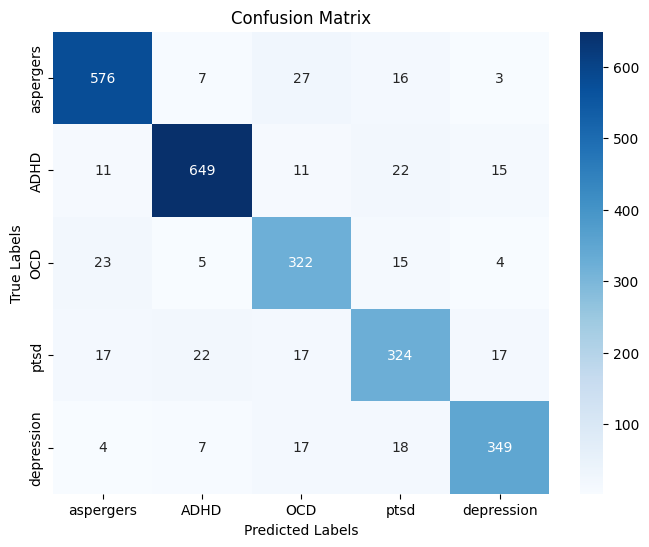

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

candidate_labels = ['aspergers', 'ADHD', 'OCD', 'ptsd', 'depression']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=candidate_labels, yticklabels=candidate_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()